In [23]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import itertools
path = "data/chap6/newsCorpora.csv"

### 50. データの入手・整形

In [2]:
# 2
df = pd.read_csv(path, sep='\t', header=None)
df.columns = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']
publishers = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
selected_df = df[df['PUBLISHER'].isin(publishers)]

In [3]:
# 3
selected_df = selected_df.sample(frac=1)

In [4]:
# 4
train_df, valid_test_df = train_test_split(selected_df, train_size=0.8)
valid_df, test_df = train_test_split(valid_test_df, train_size=0.5)
columns = ['CATEGORY','TITLE']
train_df.to_csv("data/chap6/train.txt", columns=columns, sep='\t', header=False, index=False)
test_df.to_csv("data/chap6/test.txt", columns=columns, sep='\t', header=False, index=False)
valid_df.to_csv("data/chap6/valid.txt", columns=columns, sep='\t', header=False, index=False)

In [5]:
selected_df['CATEGORY'].value_counts()

b    5627
e    5279
t    1524
m     910
Name: CATEGORY, dtype: int64

### 51. 特徴量抽出

In [6]:
vec_count = CountVectorizer()
x_train = vec_count.fit_transform(train_df['TITLE'])
x_test = vec_count.transform(test_df['TITLE'])
x_valid = vec_count.transform(valid_df['TITLE'])

np.savetxt('data/chap6/train.feature.txt', x_train.toarray(), fmt='%d') # スパース行列から密行列に変換
np.savetxt('data/chap6/valid.feature.txt', x_valid.toarray(), fmt='%d')
np.savetxt('data/chap6/test.feature.txt', x_test.toarray(), fmt='%d')

### 52. 学習

In [7]:
clf = LogisticRegression()
clf.fit(x_train, train_df['CATEGORY'])

/Users/sora/.pyenv/versions/3.8.2/envs/nlp100/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### 53. 予測

In [8]:
dic = {'b':'business', 't':'science and technology', 'e' : 'entertainment', 'm' : 'health'}
def predict(text):
    text = [text]
    x = vec_count.transform(text)
    ls_proba = clf.predict_proba(x)
    for proba in ls_proba:
        for c, p in zip(clf.classes_, proba):
            print (dic[c]+':',p)
s = train_df.iloc[0]['TITLE']
print(s)
predict(s)

UPDATE 1-Mercedes recalls 284000 cars in US, Canada over tail lights
business: 0.08633018503523582
entertainment: 0.002662581877367306
health: 0.009787056805324318
science and technology: 0.9012201762820725


### 54. 正解率の計測

In [9]:
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)
y_train = train_df['CATEGORY']
y_test = test_df['CATEGORY']
print (accuracy_score(y_train, y_train_pred))
print (accuracy_score(y_test, y_test_pred))

0.9963455772113943
0.9107946026986506


### 55. 混同行列の作成

In [10]:
labels = ['b','t','e','m']
train_cm = confusion_matrix(y_train, y_train_pred, labels=labels)
test_cm = confusion_matrix(y_test, y_test_pred, labels=labels)
train_cm_labeled = pd.DataFrame(train_cm, columns=labels, index=labels)
test_cm_labeled = pd.DataFrame(test_cm, columns=labels, index=labels)
print(train_cm_labeled)
print(test_cm_labeled)

      b     t     e    m
b  4512     7     4    0
t    13  1214     2    0
e     6     1  4199    1
m     3     0     2  708
     b    t    e   m
b  517   20   21   3
t   23  106   11   0
e    5    6  531   3
m   14    3   10  61


### 56. 適合率，再現率，F1スコアの計測

In [11]:
ps = precision_score(y_test, y_test_pred, average=None, labels=labels)
rs = recall_score(y_test, y_test_pred, average=None, labels=labels)
f1 = f1_score(y_test, y_test_pred, average=None, labels=labels)

df = pd.DataFrame(data={'precision score': ps, 'recall score': rs, 'f1 score': f1}, index = labels)
print(df)

   precision score  recall score  f1 score
b         0.924866      0.921569  0.923214
t         0.785185      0.757143  0.770909
e         0.926702      0.974312  0.949911
m         0.910448      0.693182  0.787097


In [12]:
micro_ps = precision_score(y_test, y_test_pred, average='micro', labels=labels)
micro_rs = recall_score(y_test, y_test_pred, average='micro', labels=labels)
micro_f1 = f1_score(y_test, y_test_pred, average='micro', labels=labels)

micro_df = pd.DataFrame(data={'precision score': micro_ps, 'recall score': micro_rs, 'f1 score': micro_f1}, index = labels)
print(micro_df)

   precision score  recall score  f1 score
b         0.910795      0.910795  0.910795
t         0.910795      0.910795  0.910795
e         0.910795      0.910795  0.910795
m         0.910795      0.910795  0.910795


In [13]:
macro_ps = precision_score(y_test, y_test_pred, average='macro', labels=labels)
macro_rs = recall_score(y_test, y_test_pred, average='macro', labels=labels)
macro_f1 = f1_score(y_test, y_test_pred, average='macro', labels=labels)

macro_df = pd.DataFrame(data={'precision score': macro_ps, 'recall score': macro_rs, 'f1 score': macro_f1}, index = labels)
print(macro_df)

   precision score  recall score  f1 score
b           0.8868      0.836551  0.857783
t           0.8868      0.836551  0.857783
e           0.8868      0.836551  0.857783
m           0.8868      0.836551  0.857783


### 57. 特徴量の重みの確認

In [14]:
names = np.array(vec_count.get_feature_names())
labels=['b','t','e','m']
for c, coef in zip(clf.classes_, clf.coef_): # カテゴリ毎に表示する
    idx = np.argsort(coef)[::-1] # 降順ソート
    print (dic[c])
    print (names[idx][:10]) # 重みの高い特徴量トップ10
    print (names[idx][-10:][::-1]) # 重みの低い特徴量トップ10

business
['bank' 'fed' 'ecb' 'ukraine' 'yellen' 'obamacare' 'euro' 'china' 'pfizer'
 'dollar']
['activision' 'cap' 'aereo' 'virus' 'ebola' 'heartbleed' 'twitch'
 'nintendo' 'she' 'pump']
entertainment
['kardashian' 'chris' 'transformers' 'paul' 'thrones' 'film' 'movie'
 'miley' 'star' 'kim']
['google' 'facebook' 'gm' 'study' 'china' 'ceo' 'billion' 'data' 'alibaba'
 'microsoft']
health
['ebola' 'fda' 'cancer' 'cases' 'study' 'drug' 'mers' 'cdc' 'cigarettes'
 'doctors']
['gm' 'dimon' 'facebook' 'climate' 'apple' 'twitter' 'play' 'netflix'
 'deal' 'sales']
science and technology
['facebook' 'google' 'apple' 'microsoft' 'climate' 'tesla' 'heartbleed'
 'nasa' 'fcc' 'moon']
['stocks' 'percent' 'valued' 'grows' 'fed' 'american' 'expands' 'concerns'
 'close' 'thrones']


### 58. 正則化パラメータの変更

In [17]:
def calc_scores(c):
    y_train = train_df['CATEGORY']
    y_test = test_df['CATEGORY']
    y_valid = valid_df['CATEGORY']
    
    clf = LogisticRegression(C=c)
    clf.fit(x_train, y_train)
    
    y_train_pred = clf.predict(x_train)
    y_test_pred = clf.predict(x_test)
    y_valid_pred = clf.predict(x_valid)
    
    scores = []
    scores.append(accuracy_score(y_train, y_train_pred))
    scores.append(accuracy_score(y_valid, y_valid_pred))
    scores.append(accuracy_score(y_test, y_test_pred))
    return scores

/Users/sora/.pyenv/versions/3.8.2/envs/nlp100/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sora/.pyenv/versions/3.8.2/envs/nlp100/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

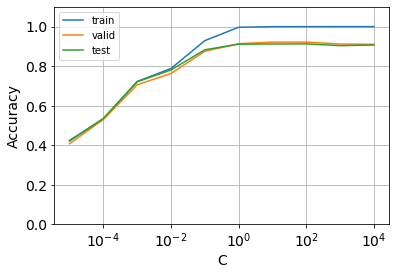

In [21]:
C = np.logspace(-5, 4, 10, base=10)
scores = []
for c in C:
    scores.append(calc_scores(c))
scores = np.array(scores).T
labels = ['train', 'valid', 'test']

for score, label in zip(scores,labels):
    plt.plot(C, score, label=label)
plt.ylim(0, 1.1)
plt.xscale('log')
plt.xlabel('C', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.legend()

### 59. ハイパーパラメータの探索

In [22]:
def calc_scores(c, solver, class_weight):
    y_train = train_df['CATEGORY']
    y_test = test_df['CATEGORY']
    y_valid = valid_df['CATEGORY']
    
    clf = LogisticRegression(C=c, solver=solver, class_weight=class_weight)
    clf.fit(x_train, y_train)
    
    y_train_pred = clf.predict(x_train)
    y_test_pred = clf.predict(x_test)
    y_valid_pred = clf.predict(x_valid)
    
    scores = []
    scores.append(accuracy_score(y_train, y_train_pred))
    scores.append(accuracy_score(y_valid, y_valid_pred))
    scores.append(accuracy_score(y_test, y_test_pred))
    return scores

In [30]:
C = np.logspace(-5, 4, 10, base=10)
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
class_weight = [None, 'balanced']
scores = []

for c, s, w in itertools.product(C, solver, class_weight):
    scores.append({'score': calc_scores(c, s, w), 'solver':s, 'class_weight':w})

/Users/sora/.pyenv/versions/3.8.2/envs/nlp100/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/sora/.pyenv/versions/3.8.2/envs/nlp100/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/sora/.pyenv/versions/3.8.2/envs/nlp100/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/sora/.pyenv/versions/3.8.2/envs/nlp100/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/s

In [33]:
scores.sort(key=lambda x: x['score'][1], reverse=True)
print(scores[0])

{'score': [0.9990629685157422, 0.9272863568215892, 0.9175412293853074], 'solver': 'liblinear', 'class_weight': 'balanced'}
